## Ejercicios

### 2. Análisis de Sentimiento

Implementación y evaluación de un modelo de análisis de sentimiento.

El objetivo principal es el de realizar un **modelo de clasificación binaria**. Se valorará positivamente comparar la variación en los resultados al usar **diferentes modelos**, al **modificar algún paso en la etapa de preprocesado** (stemming vs no stemming, p.ej.), así como la comparación de resultados utilizando o bien **modelos pre-entrenados** o modelos más simples (como VADER).

Se utilizará alguno de los datasets disponibles de **reviews de Amazon**.

Soluciones más avanzadas como por ejemplo modelos de clasificación multi-clase o basados en embeddings serán valorables.

In [24]:

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.utils import shuffle

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import unicodedata
import string
from num2words import num2words 
from stop_words import get_stop_words 


## Carga y separación en train y test

In [25]:
data= pd.read_csv('../../Dataset/data.csv')

In [26]:
#Compruebo que se han cargado correctamente los datos
len(data)

36004

In [27]:
#ídem
data.head()

,helpful,reviewText,overall,category
0,"[4, 4]",This is a fantastic product that is well made....,1,Musical_Instruments
1,"[2, 3]",I was never able to get this to extend and tha...,1,Patio_Lawn_and_Garden
2,"[0, 0]",It arrived quickly and good packing. but I hav...,5,Automotive
3,"[0, 0]",prints are sharp with great color saturation. ...,5,Office_Products
4,"[7, 7]",I used to buy a lot of wire form these guys......,1,Musical_Instruments


In [28]:
#nos vamos a crear una función que nos devuelva los valores inferiores de 3 como "neg" y lo superiores como "pos; ignorando los =3 que son neutros
 
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [29]:
#aplicamos la función y revisamos los resultados

data['sentiment_label'] = data.apply(label_sentiment, axis=1) 

data.head()

,helpful,reviewText,overall,category,sentiment_label
0,"[4, 4]",This is a fantastic product that is well made....,1,Musical_Instruments,neg
1,"[2, 3]",I was never able to get this to extend and tha...,1,Patio_Lawn_and_Garden,neg
2,"[0, 0]",It arrived quickly and good packing. but I hav...,5,Automotive,pos
3,"[0, 0]",prints are sharp with great color saturation. ...,5,Office_Products,pos
4,"[7, 7]",I used to buy a lot of wire form these guys......,1,Musical_Instruments,neg


In [30]:
#nos vamos a crear un dataset con las reviews y a eliminarnos los NAs

rtext = data[['reviewText','category','sentiment_label']]
rtext.dropna(subset=['reviewText','category', 'sentiment_label'], inplace=True)

C:\Users\paula\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
def text_normalizer(text, lemmatize=False, sw_list=None):
    
    processed_text = []
    
    if sw_list is None:
        sw_list = []
    
    if lemmatize:
        lemmas_dict = get_lemmas_dict()
    
    if type(text) is str:
        # Convierte el texto a minúsuculas
        text = text.lower()

        # Eliminar caracteres "extraños"
        text = unicodedata.normalize('NFKC', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        # Tabla para eliminar signos de puntuación
        table = str.maketrans('', '', string.punctuation)

        # Segmentar texto en frases
        sentences = text.split('.')

        # Para cada frase
        for sentence in sentences:
            words = sentence.split(' ')
            # Para cada palabra
            for word in words:
                if word not in string.punctuation and word not in sw_list:  # Si se pasa, elimina stop words
                    word = word.translate(table)
                    if lemmatize:
                        word = lemmas_dict.get(word, word)
                    if word.isdigit():
                        word = num2words(word, lang='es')
                processed_text.append(word)

        return ' '.join(processed_text)
    return " "
        

In [32]:
#aplicamos la función y revisamos los resultados

rtext['reviewText_aux'] = rtext.apply(lambda row: text_normalizer (row['reviewText'],sw_list =gensim.parsing.preprocessing.STOPWORDS), axis=1) 

rtext.head()

C:\Users\paula\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reviewText,category,sentiment_label,reviewText_aux
0,This is a fantastic product that is well made....,Musical_Instruments,neg,this is a fantastic product that is well made ...
1,I was never able to get this to extend and tha...,Patio_Lawn_and_Garden,neg,i was never able to get this to extend and tha...
2,It arrived quickly and good packing. but I hav...,Automotive,pos,it arrived quickly and good packing but i hav...
3,prints are sharp with great color saturation. ...,Office_Products,pos,prints are sharp with great color saturation ...
4,I used to buy a lot of wire form these guys......,Musical_Instruments,neg,i used to buy a lot of wire form these guys ...


In [33]:
#separamos en train y test

X_train, X_test, y_train, y_test = train_test_split(
    rtext['reviewText_aux'],
    rtext['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify= rtext['sentiment_label']
) 

In [34]:
#revisamos que haya separado correctamente las líneas según lo indicado x= reviews e y= si la valoración es positiva o negativa
X_train.iloc[:10] 

21832    the uniden tcx905 offers all the same features...
23382    these envelopes are thicker than i expected an...
32597    i bought this belt for my dos mil tres chevy t...
1250     not worth the money  just use an old cotton ts...
4812     worked great for the intended purpose   nothin...
1258     wow - treinta y tres for a mesh thing  is this...
25291    when vine sent me this to try out i have to ad...
11426    works great  its lightweight but very stable e...
5052     if using these pens to draw the illustrious pr...
26258    works well since i got it  i didnt change batt...
Name: reviewText_aux, dtype: object

In [35]:
y_train.iloc[:10] 

21832    pos
23382    pos
32597    pos
1250     pos
4812     pos
1258     pos
25291    pos
11426    pos
5052     pos
26258    pos
Name: sentiment_label, dtype: object

### Extracción de features


In [36]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=20000,
    strip_accents='ascii',
    ngram_range=(2, 3)
)
cv.fit(X_train) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95,
                max_features=20000, min_df=5, ngram_range=(2, 3), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents='ascii', sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [37]:
print(list(cv.vocabulary_.items())) 

[('all the', 265), ('the same', 15190), ('as the', 1731), ('that came', 13831), ('came with', 2872), ('with several', 19208), ('several other', 12753), ('it is', 7686), ('is solid', 7334), ('with the', 19221), ('the cinco', 14310), ('as one', 1702), ('one of', 10960), ('of this', 10554), ('have found', 6001), ('found that', 5150), ('that can', 13833), ('from the', 5202), ('the base', 14156), ('base and', 1982), ('and it', 827), ('it will', 7991), ('will still', 19053), ('my home', 9604), ('home and', 6327), ('and yard', 1268), ('are not', 1496), ('not huge', 10026), ('but still', 2716), ('still had', 13414), ('had problems', 5779), ('problems with', 11939), ('with my', 19177), ('my older', 9652), ('had to', 5792), ('if was', 6535), ('outside in', 11355), ('in order', 6777), ('order to', 11197), ('to get', 16842), ('get my', 5318), ('my old', 9650), ('to receive', 17121), ('the signal', 15253), ('but with', 2762), ('there is', 15700), ('is no', 7244), ('no need', 9924), ('need to', 9773

In [38]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test) 

In [39]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i])) 

ID: 23491
Sentiment: pos
Review: i have been using this tester for about a year to test out my xlr cables and those that i come into contact with at work  it works but does not detect all faults only non intermittent ones it comes in a durable enough housing and is compact enough to take everywhere 


In [40]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

#aquí vemos las palabras con más y menos frecuencia de aparición

Top 10 words with highest TF_IDF in the review 23491:
                   tfidf
for about year  0.222694
is compact      0.221473
ones it         0.220305
it works but    0.216073
come into       0.215110
year to         0.209948
and those       0.202445
those that      0.201277
it comes in     0.199079
cables and      0.197540

Top 10 words with lowest TF_IDF in the review 23491:
               tfidf
for about   0.141343
to take     0.137839
it comes    0.137277
using this  0.128994
been using  0.127204
and is      0.120058
enough to   0.117428
does not    0.116788
have been   0.114273
it works    0.108524


<>:14: DeprecationWarning: invalid escape sequence \c
<>:16: DeprecationWarning: invalid escape sequence \c
<>:14: DeprecationWarning: invalid escape sequence \c
<>:16: DeprecationWarning: invalid escape sequence \c
<>:14: DeprecationWarning: invalid escape sequence \c
<>:16: DeprecationWarning: invalid escape sequence \c
<ipython-input-41-5bfac36232f6>:14: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('$\chi^2$', fontsize=26)
<ipython-input-41-5bfac36232f6>:16: DeprecationWarning: invalid escape sequence \c
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


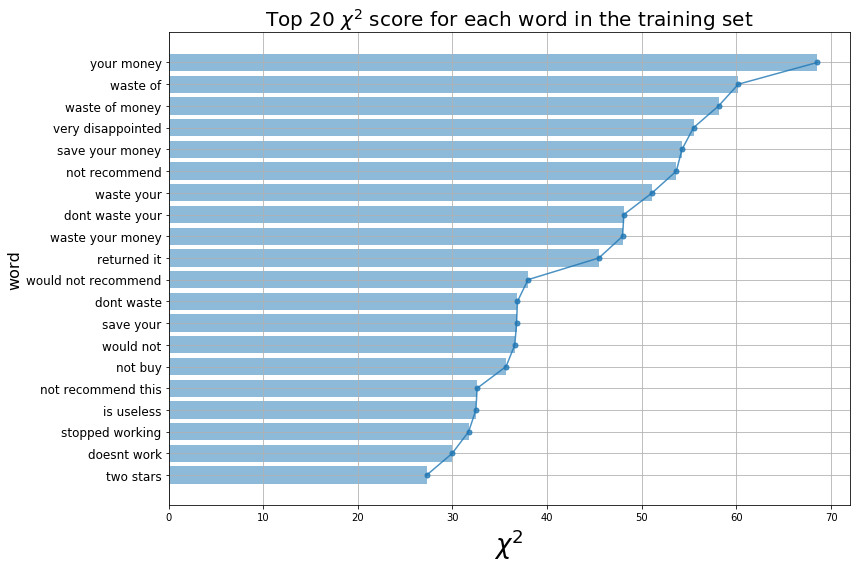

In [41]:
i = 20

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Entrenamiento

In [42]:
c_params = [0.05, 0.25, 0.5, 1, 10, 100, 1000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=0.05: 0.9418695120595754


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=0.25: 0.9418695120595754


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=0.5: 0.9419806602200733


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=1: 0.9432032899855507


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=10: 0.9488718461709459


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=100: 0.9478715127264644


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Accuracy for C=1000: 0.9438701789485384


C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:329: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
C:\Users\paula\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:350: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  t

Vemos que la Accuracy es de 0.9438701789485384 lo que nos indica que EN PRINCIPIO no vamos mal o que vamos DEMASIADO bien


### Algunas métricas


In [47]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 163  360]
 [ 145 8329]]

Classification report:
              precision    recall  f1-score   support

         neg       0.53      0.31      0.39       523
         pos       0.96      0.98      0.97      8474

    accuracy                           0.94      8997
   macro avg       0.74      0.65      0.68      8997
weighted avg       0.93      0.94      0.94      8997

Accuracy score:0.9438701789485384


Vemos que el modelo funciona bastante bien para los comentarios positivos y falla con los negativos

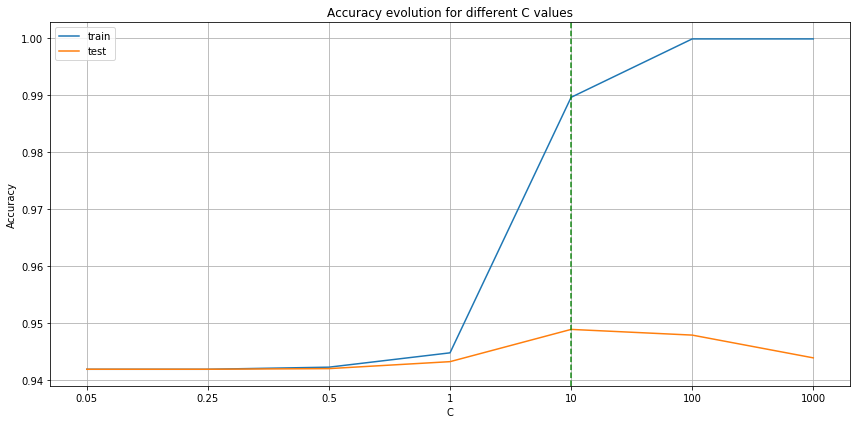

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.9)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

### Predecir

In [52]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(rtext.iloc[review_index]['sentiment_label']))
    r = rtext.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [62]:
for i in random.sample(range(0, len(rtext)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 23976
Actual sentiment: pos
Prediction: ['pos']

Review no. 3371
Actual sentiment: pos
Prediction: ['pos']

Review no. 30922
Actual sentiment: pos
Prediction: ['pos']

Review no. 11512
Actual sentiment: pos
Prediction: ['pos']

Review no. 2591
Actual sentiment: pos
Prediction: ['pos']

Review no. 6289
Actual sentiment: pos
Prediction: ['pos']

Review no. 10327
Actual sentiment: pos
Prediction: ['pos']

Review no. 16721
Actual sentiment: pos
Prediction: ['pos']

Review no. 29224
Actual sentiment: pos
Prediction: ['pos']

Review no. 10675
Actual sentiment: neg
Prediction: ['neg']


Comprobamos y vemos que, sobre el papel, el modelo no funciona mal